In [1]:
import numpy as np
import tensorflow as tf
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing//')
from Metric import *
from Visualization import *
from Data_Extractor import *
from Restored_Classifier import *
from sklearn.externals import joblib

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
# settings
area = 'coombs' # coombs

path_image = "../../Data/Data_in_T/" + area + "_scene.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/road_mask.tif"
    
# sk-SGD_weight_m5_p1_e15_r1  
# sk-SGD_weight_G0.0001_p0_e15_rNone
# Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0

# classifier_type = 'LR'
# path_model_dir = "../Segmentation-Central-Pixel/Result/motor_trunk_pri_sec_tert_uncl_track/sklearn/"
# model_name = "sk-SGD_weight_G0_0001_p0_e15_rNone"
# size = 8
# step = 1

# classifier_type = 'FCN'
# path_model_dir = "../Segmentation-FCN/Result/Inception/Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0/"
# model_name = "Incep_1-32;3-32|1-64;3-64|1-128;3-128_G_weight_p0_e20_r0"
# size = 128
# step = 7

classifier_type = 'FCN'
path_model_dir = "../Segmentation-FCN/Result/FCN/FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0/"
model_name = "FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19"
size = 128
step = 7


path_pred_dir = "./Result/Pred/" + area + "/" + model_name
if not path_pred_dir.endswith('/'): path_pred_dir = path_pred_dir + '/'
path_pred_in_time = path_pred_dir + model_name + '.h5'
print(path_pred_in_time)

use_norm = True
if model_name.find("_G") > 0:
    norm = "Gaussian"
elif model_name.find("_m") > 0:
    norm = "mean"
else:
    norm = None
    use_norm = False

./Result/Pred/coombs/FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19/FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19.h5


In [15]:
# re-load classifier
classifier = Classifier(path_model_dir, model_name, classifier_type)

INFO:tensorflow:Restoring parameters from ../Segmentation-FCN/Result/FCN/FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0/FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19


In [ ]:
# get date list
h5f = h5py.File(path_image, 'r')
date_list = sorted([i for i in h5f['scene'].keys()], key= lambda x:x)
h5f.close()

for date in date_list:

    # check prediction not existing
    h5f = h5py.File(path_pred_in_time, 'a')
    if date in set([pred for pred in h5f.keys()]):
        print(date, 'already predicted, skip')
        h5f.close()
        continue
    else:
        print('predicting', date)
        h5f.close()
    
    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    # construct extractor
    data_extractor = Pred_Data_Extractor(raw_image, step=step, size=size,
                                         normalization=norm, classifier_type=classifier_type)
    
    # pred on image
    if classifier_type == 'LR':
        pred_road = np.zeros(shape=raw_image[0].shape)
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]+int(size/2),coord[1]+int(size/2)] = classifier.predict(patch)

    else: # FCN        
        pred_road = np.zeros(shape=(raw_image.shape[1], raw_image.shape[2], 2))
        print(pred_road.shape, date)

        for coord, patch in data_extractor.iterate_raw_image_patches_with_coord(norm=use_norm):
            pred_road[coord[0]:coord[0]+size, coord[1]:coord[1]+size] += classifier.predict(patch)
            
    # save prediction
    h5f = h5py.File(path_pred_in_time, 'a')
    h5f.create_dataset(name=date, data=pred_road)
    h5f.close()

Analyze pred along the time

In [16]:
def get_patch(coord, mask, size):
    return mask[coord[0]:coord[0]+size, coord[1]:coord[1]+size]

def load_raw_and_pred(path_image, path_pred_in_time, date, classifier_type):
    # load prediction 
    h5f = h5py.File(path_pred_in_time, 'a')
    pred_road = np.array(h5f[date])
    h5f.close()

    # load raw image
    h5f = h5py.File(path_image, 'r')
    raw_image = np.array(h5f['scene'][date])
    h5f.close()
    
    if classifier_type == 'FCN':
        pred_road, invalid_pred_mask = pred_normalization(pred_road)
    else:
        invalid_pred_mask = (pred_road == 0)

    
    return raw_image, pred_road, invalid_pred_mask

#######################################################

def pred_normalization(pred):
    pred_norm = pred[:,:,1]/pred.sum(axis=-1)
    invalid_mask = pred_norm != pred_norm
    
    pred_norm[np.where(invalid_mask)] = 0
    pred_norm[np.where(pred_norm == np.float('inf'))] = 1
    
    return pred_norm, invalid_mask

# softmax
def pred_softmax(pred):
    threshold = 500
    pred_exp = pred.copy()
    inf_idx = np.where(pred_exp > threshold)
    
    for x, y in zip(inf_idx[0], inf_idx[1]):
        while((pred_exp[x,y] > threshold).any()):
            pred_exp[x,y] = pred_exp[x,y] / 10
    pred_exp = np.exp(pred_exp[:,:,1])/np.exp(pred_exp).sum(axis=-1)
    pred_exp[np.where(pred[:,:,1] == 0)] = 0 # softmax([0,0]) = (0.5, 0.5)
    return pred_exp

def get_log_pred(pred):
    log_pred = -np.log(-pred + 1 + 1e-9)
    norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
    return norm_log_pred

#######################################################

def time_diff(img_old, img_new):
    img_diff = img_new - img_old
    if len(img_diff.shape) == 2:
        img_diff = (img_diff - img_diff.min()) / (img_diff.max() - img_diff.min())
    else:
        for band_idx in range(img_diff.shape[0]):
            img_diff[band_idx] = (img_diff[band_idx] - img_diff[band_idx].min()) / (img_diff[band_idx].max() - img_diff[band_idx].min())
    
    img_diff[np.where(img_diff != img_diff)] = 0    
    return img_diff

def average_in_year(path_image, path_pred_in_time, date_list, year, raw_shape, road_shape, classifier_type):
    valid_road_cnt = np.zeros(shape=road_shape)
    pred_road = np.zeros(shape=road_shape)
    valid_raw_cnt = np.zeros(shape=raw_shape)
    raw_image = np.zeros(shape=raw_shape)
    
    for date in date_list:
        if year not in date: continue
        
        cur_raw, cur_pred, cur_invalid_pred = load_raw_and_pred(path_image, path_pred_in_time, 
                                                                date, classifier_type)
        
        valid_idx = np.where(cur_invalid_pred == 0)
        valid_road_cnt[valid_idx] = valid_road_cnt[valid_idx] + 1
        pred_road[valid_idx] = pred_road[valid_idx] + cur_pred[valid_idx]
        
        valid_idx = np.where(cur_raw != -9999)
        valid_raw_cnt[valid_idx] = valid_raw_cnt[valid_idx] + 1
        raw_image[valid_idx] = raw_image[valid_idx] + cur_raw[valid_idx]
        gc.collect()
    
    pred_road = pred_road/valid_road_cnt
    raw_image = raw_image/valid_raw_cnt

    invalid_idx = np.where(valid_road_cnt == 0)
    pred_road[invalid_idx] = 0
    invalid_idx = np.where(valid_raw_cnt == 0)
    raw_image[invalid_idx] = -9999
    
    return raw_image, pred_road

In [17]:
# load road mask & date list
h5f = h5py.File(path_image, 'r')
road_mask = np.array(h5f['road'])
date_list = sorted([i for i in h5f['scene'].keys()], key= lambda x:x)
h5f.close()

# get sample raw image
h5f = h5py.File(path_image, 'r')
raw_image = np.array(h5f['scene'][date_list[0]])
h5f.close()

gc.collect()

7

In [ ]:
# visualise prediction

for date in date_list:

    raw_image, pred_road, _ = load_raw_and_pred(path_image, path_pred_in_time, date, classifier.classifier_type)
        
    plt.close('all')    
    plt.figure(figsize=(20,20))
    
    road_mask_RGB = np.zeros(shape=list(road_mask.shape) + [3])
    road_mask_RGB[:,:,0] = road_mask_RGB[:,:,0] + pred_road # pred in R channel
    road_mask_RGB[:,:,2] = road_mask_RGB[:,:,2] + road_mask # true in B channel
    plt.imshow(road_mask_RGB)
    plt.savefig(path_pred_dir+'road_pred/'+date)
    plt.close()

    plt.figure(figsize=(20,20))
    plt.imshow(pred_road)
    plt.savefig(path_pred_dir+'only_pred/'+date)
    plt.close()
    
    show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred/'+date)
    
    show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
                            show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+date)
    

In [ ]:
# denoising - time diff

plt.close('all')
for date_old, date_new in zip(date_list, date_list[1:]):
    
    print(date_old, date_new)
    
    raw_old, pred_old = load_raw_and_pred(path_image, path_pred_in_time, date_old, classifier.classifier_type)
    raw_new, pred_new = load_raw_and_pred(path_image, path_pred_in_time, date_new, classifier.classifier_type)

    pred_diff = time_diff(pred_old, pred_new)
    raw_diff  = time_diff(raw_old, raw_new)

    plt.figure(figsize=(20,20))
    plt.imshow(pred_diff)
    plt.savefig(path_pred_dir+'pred_diff/' + date_old+'-'+date_new)
    plt.close()

In [7]:
def add_circle(ax, year, area, c='y', lw = 3):
    assert area in ['googong', 'coombs']
    # (LR, TD)
    circle_list = []
    linewidth = lw
    
    if area == 'googong':
        if year == '2013-2015':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((210, 120), 30, color=c, fill=False, lw=linewidth))        
            circle_list.append(plt.Circle((200, 500), 25, color=c, fill=False, lw=linewidth))
        if year == '2015-2013':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017

        if year == '2015-2017':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((210, 120), 30, color=c, fill=False, lw=linewidth))

            circle_list.append(plt.Circle((340, 140), 20, color=c, fill=False, lw=linewidth))
            circle_list.append(plt.Circle((225, 170), 20, color=c, fill=False, lw=linewidth))


        if year == '2013':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((210, 120), 30, color=c, fill=False, lw=linewidth))

            circle_list.append(plt.Circle((200, 500), 25, color=c, fill=False, lw=linewidth))

        if year == '2015':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((210, 120), 30, color=c, fill=False, lw=linewidth))

            circle_list.append(plt.Circle((200, 500), 25, color=c, fill=False, lw=linewidth))

            circle_list.append(plt.Circle((340, 140), 20, color=c, fill=False, lw=linewidth))
            circle_list.append(plt.Circle((225, 170), 20, color=c, fill=False, lw=linewidth))
        if year == '2017':
            circle_list.append(plt.Circle((488, 265), 58, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((210, 120), 30, color=c, fill=False, lw=linewidth))

            circle_list.append(plt.Circle((340, 140), 20, color=c, fill=False, lw=linewidth))
            circle_list.append(plt.Circle((225, 170), 20, color=c, fill=False, lw=linewidth))             

    if area == 'coombs':
        if year == '2013-2015':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((190, 50), 15, color=c, fill=False, lw=linewidth)) # 2013 2015
        if year == '2015-2013':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((230, 170), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017

        if year == '2015-2017':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((248, 148), 6, color=c, fill=False, lw=linewidth)) # 2015 2017
        if year == '2017-2015':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((120, 200), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017


        if year == '2013':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((190, 50), 15, color=c, fill=False, lw=linewidth)) # 2013 2015

            circle_list.append(plt.Circle((230, 170), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017

        if year == '2015':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((190, 50), 15, color=c, fill=False, lw=linewidth)) # 2013 2015
            circle_list.append(plt.Circle((230, 170), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017

            circle_list.append(plt.Circle((248, 148), 6, color=c, fill=False, lw=linewidth)) # 2015 2017
            circle_list.append(plt.Circle((120, 200), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017

        if year == '2017':
            circle_list.append(plt.Circle((160, 100), 40, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
            circle_list.append(plt.Circle((248, 148), 6, color=c, fill=False, lw=linewidth)) # 2015 2017

            circle_list.append(plt.Circle((120, 200), 20, color=c, fill=False, lw=linewidth)) # 2013 2015 2017
    
    # add into plot
    for circle in circle_list:
        ax.add_artist(circle)

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0.993171665910853 0.0 0.18688357922126464
0.9909361151801693 0.0 0.20099594835997459
0.9885574843910301 0.0 0.21047826203023373
0.7509862055301585 0.009815019543598532
0.8339712245463256 0.008662506099807569
0.5403198035739379 0.006115317191587036
0.8058064825905613 0.007240937099363229


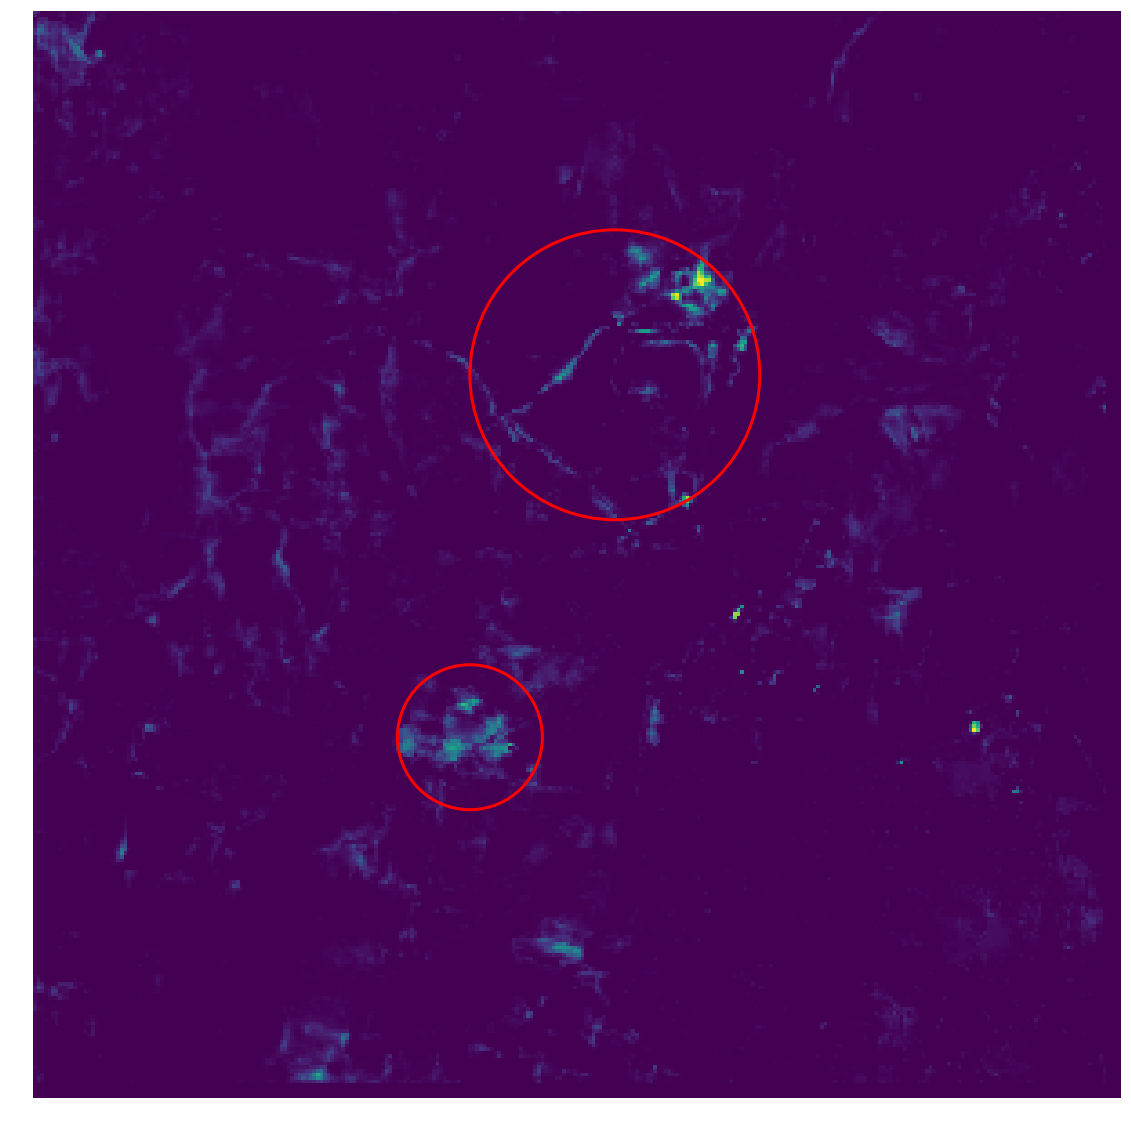

In [18]:
# denoising - time average on year

raw_shape  = raw_image.shape
road_shape = road_mask.shape
figsize = (20,20)

# [2013,2014,2015,2016,2017]
# [2013,2015,2017]
year_list = [str(y) for y in [2013, 2015, 2017]]
for year in year_list:
    raw_image, pred_road = average_in_year(path_image, path_pred_in_time, date_list, year, 
                                           raw_shape, road_shape, classifier_type)
    
    pred_road = pred_road**2
    print(pred_road.max(), pred_road.min(), pred_road.mean())
    plt.close('all')
    
    # raw image over year
    show_raw_image(raw_image, size=-1, figsize=figsize, 
                   show_plot=False, close_plot=False)
    add_circle(plt.gca(), year, area)
    
    save_path=path_pred_dir+'raw_pred/'+year+'_raw'
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', transperant=True)
    
    # road pred over year
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.imshow(pred_road)
    add_circle(plt.gca(), year, area, 'r')

    plt.axis('off')
    plt.savefig(path_pred_dir+'only_pred/'+year, bbox_inches='tight', transperant=True)
    
    # road pred on raw over year
    plt.close('all')
    show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=figsize, 
                            show_plot=False, close_plot=False)
    add_circle(plt.gca(), year, area)

    save_path=path_pred_dir+'raw_pred/'+year
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', transperant=True)
    
    if year == '2017':
        plt.close('all')
        show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=figsize, 
                                show_plot=False, close_plot=False)
        add_circle(plt.gca(), year, area)
        
        save_path = path_pred_dir+'raw_pred/'+year + '_on_road'
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', transperant=True)

# visualise diff
for year_old, year_new in zip(year_list[:-1] + year_list[1:], year_list[1:] + year_list[:-1]):
    raw_old, pred_old = average_in_year(path_image, path_pred_in_time, date_list, year_old, 
                                        raw_shape, road_shape, classifier_type)
    raw_new, pred_new = average_in_year(path_image, path_pred_in_time, date_list, year_new, 
                                        raw_shape, road_shape, classifier_type)
    raw_diff  = raw_new - raw_old
    pred_diff = pred_new - pred_old

    pred_diff[np.where(pred_diff<0)] = 0
    pred_diff = (pred_diff-pred_diff.min())**2
    
#     pred_diff = get_log_pred((pred_diff-pred_diff.min())/(pred_diff.max()-pred_diff.min()))    
    print(pred_diff.max(), pred_diff.mean())
    
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.imshow(pred_diff)
    add_circle(plt.gca(), year_old+'-'+year_new, area, 'r')
    plt.axis('off')
    plt.savefig(path_pred_dir+'pred_diff/'+year_old+'-'+year_new, 
                bbox_inches='tight', transparent=True)
    
#     show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred/'+year)
    
#     show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+year)   

In [ ]:
[(x,y) for x,y in zip(year_list + year_list, year_list[1:] + year_list)]

In [ ]:
print(year_list[:-1] + year_list[1:])
print(year_list[1:] + year_list[:-1])

In [ ]:
year_list

In [ ]:
# denoising - time diff after average

raw_shape  = raw_image.shape
road_shape = road_mask.shape

# [2013,2014,2015,2016,2017]
# [2013,2015,2017]
# [2017,2015,2013]
year_list = [str(y) for y in [2017,2015,2013]]

for year_old, year_new in zip(year_list, year_list[1:]):
    raw_old, pred_old = average_in_year(path_image, path_pred_in_time, date_list, year_old, 
                                        raw_shape, road_shape)
    raw_new, pred_new = average_in_year(path_image, path_pred_in_time, date_list, year_new, 
                                        raw_shape, road_shape)
    
    raw_diff  = raw_new - raw_old
    pred_diff = pred_new - pred_old
    
    plt.close('all')
    plt.figure(figsize=(20,20))
    
    pred_diff[np.where(pred_diff<0)] = 0
    
    pred_diff = (pred_diff-pred_diff.min())**2
    print(pred_diff.max(), pred_diff.mean())
#     pred_diff[np.where(pred_diff<0.5)]=0
    plt.imshow(pred_diff)
    plt.axis('off')
    plt.show()
    plt.close('all')    
    
#     show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred/'+year)
    
#     show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+year)        

In [ ]:
# denoising - time diff after average ----- adding circle

raw_shape  = raw_image.shape
road_shape = road_mask.shape

# [2013,2014,2015,2016,2017]
# [2013,2015,2017]
# [2017,2015,2013]


def add_circle(ax):
    # (LR, TD)
    circle_list = []
    circle_list.append(plt.Circle((160, 100), 40, color='y', fill=False)) # 2013 2015 2017
    circle_list.append(plt.Circle((190, 50), 15, color='y', fill=False)) # 2013 2015
    circle_list.append(plt.Circle((240, 180), 15, color='y', fill=False)) # 2013 2015
    circle_list.append(plt.Circle((250, 150), 5, color='y', fill=False)) # 2015 2017
    for circle in circle_list:
        ax.add_artist(circle)

year_old = '2015'
year_new = '2013'
raw_old, pred_old = average_in_year(path_image, path_pred_in_time, date_list, year_old, 
                                    raw_shape, road_shape)
raw_new, pred_new = average_in_year(path_image, path_pred_in_time, date_list, year_new, 
                                    raw_shape, road_shape)

raw_diff  = raw_new - raw_old
pred_diff = pred_new**2 - pred_old**2

plt.close('all')
plt.figure(figsize=(20,20))

pred_diff[np.where(pred_diff<0)] = 0
#     pred_diff = get_log_pred((pred_diff-pred_diff.min())/(pred_diff.max()-pred_diff.min()))
pred_diff = (pred_diff-pred_diff.min())
print(pred_diff.max(), pred_diff.mean())
#     pred_diff[np.where(pred_diff<0.5)]=0

plt.imshow(pred_diff)
add_circle(plt.gca())
plt.axis('off')
plt.show()
plt.close('all')    

#     show_pred_prob_with_raw(raw_image, pred_road, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred/'+year)

#     show_pred_prob_with_raw(raw_image, pred_road, road_mask, size=-1, figsize=(20,20), 
#                             show_plot=False, save_path=path_pred_dir+'raw_pred_with_road/'+year)        

In [ ]:
raw_shape  = raw_image.shape
road_shape = road_mask.shape

year_old = '2013'
year_new = '2017'
raw_old, pred_old = average_in_year(path_image, path_pred_in_time, date_list, year_old, 
                                    raw_shape, road_shape)
raw_new, pred_new = average_in_year(path_image, path_pred_in_time, date_list, year_new, 
                                    raw_shape, road_shape)

raw_diff  = raw_new - raw_old
pred_diff = pred_new - pred_old

plt.close('all')
plt.figure(figsize=(20,20))
plt.imshow((pred_diff-pred_diff.min())**2)
plt.show()

plt.close('all')
plt.figure(figsize=(20,20))
plt.imshow((-pred_diff - (-pred_diff).min())**2)
plt.show()

# show_raw_image(np.exp(raw_diff), size=-1, figsize=(20,20), 
#                show_plot=False, save_path=path_pred_dir+'raw_diff/'+year_old+'-'+year_new)

# show_raw_image(np.exp(raw_diff), size=-1, figsize=(20,20), 
#                show_plot=False, save_path=path_pred_dir+'raw_diff/'+year_old+'-'+year_new+'_exp')